In [1]:
from keras.models import load_model
from keras.applications.resnet import preprocess_input
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

Using TensorFlow backend.


In [ ]:
print("[INFO] loading model...")
model = load_model(r"C:\Users\khan1\Desktop\Projective_transform\VGG16TL_weed_classification.h5")
print("model loaded!")

In [ ]:
#Load original image, in real case it will video frame
img = cv2.imread(r'C:\Users\khan1\Desktop\Projective_transform\ragweed_front.jpg')
height = img.shape[0]
width = img.shape[1]
print("height",height,"width",width)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
start = time.time()

image = cv2.resize(img, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
x = np.expand_dims(image, axis=0)

print(x.shape)

preds = model.predict(x)[0]
label = ['cocklebur','pigweed','ragweed']

results = []
for i in range(len(label)):
    result = [label[i] , preds[i]]
    results.append(result)
    #'results' give final detect object 'label' and 'prediction' in list format::
    # results=[['cocklebur', 0.0], ['pigweed', 0.0], ['ragweed', 1.0]]

label = [results[0][0],results[1][0],results[2][0]]
proba = [results[0][1],results[1][1],results[2][1]]

label1 = "{}: {:.2f}%".format(label[0], proba[0] * 100)
label2 = "{}: {:.2f}%".format(label[1], proba[1] * 100)
label3 = "{}: {:.2f}%".format(label[2], proba[2] * 100)

end = time.time()
print("time needed to process: ", end - start,"seconds")


output = cv2.resize(img, (width,height)) 
cv2.putText(output, label1, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,0.7, (125, 125, 0), 2)
cv2.putText(output, label2, (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
cv2.putText(output, label3, (10, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
# cv2.putText(output, totaltime, (320, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
# cv2.putText(output, fpscounter, (320, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Classification output")
plt.show()

## Classification to Detection

1. Input: An image that we wish to apply object detection to
2. Output: Three values, including:\
2a. A list of bounding boxes, or the (x, y)-coordinates for each object in an image\
2b. The class label associated with each of the bounding boxes\
2c. The probability/confidence score associated with each bounding box and class label

Use sliding window to extract class label and prediction. At each stop of the sliding window we would:
1. Extract the ROI
2. Pass it through our image classifier (CNN)
3. Obtain the output predictions

Combined with image pyramids, sliding windows allow us to localize objects at different locations and multiple scales of the input image.

When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image. The solution to the problem is to apply non-maxima suppression (NMS), which collapses weak, overlapping bounding boxes in favor of the more confident ones.

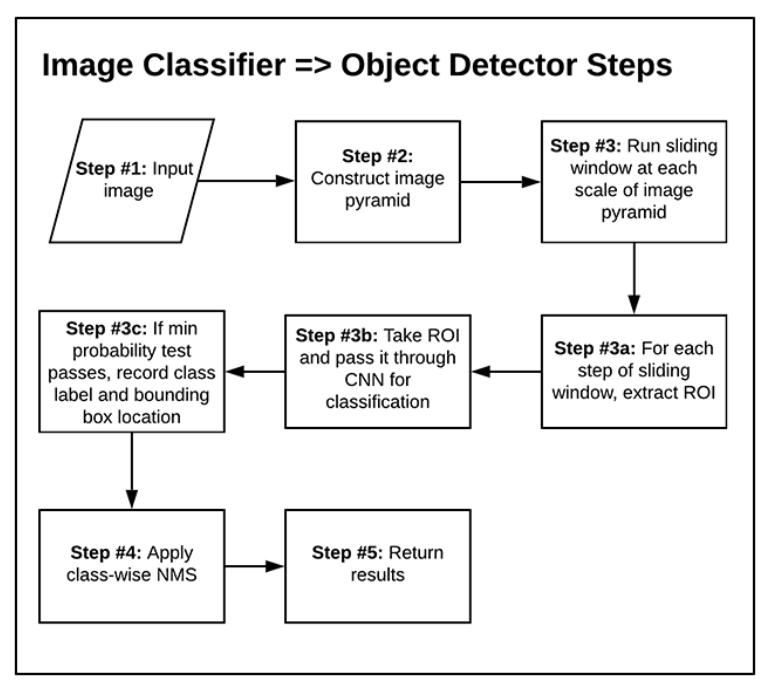

3 step procedure to conver classifier into detector:
1. Image pyramids: Localize objects at different scales/sizes.
2. Sliding windows: Detect exactly where in the image a given object is.
3. Non-maxima suppression: Collapse weak, overlapping bounding boxes.

In [2]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [3]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [4]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image

    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = resize(image, width=w)
        
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image

In [5]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [6]:
def decode_prediction(predictions, labels):
#     """
#     #Input: class labels:: labels = ['cocklebur','pigweed','ragweed']
#     #Input: predictions:: Numpy array encoding a batch of predictions. #preds = model.predict(rois)
    
#     #Output: lists of top class prediction tuples
#     #print(np.array(results).shape): (num_of_roi, 3, 2)
#     #print(results): [[('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                     [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 1.05910075e-35), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 5.5419554e-18), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 3.087203e-16), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 9.03492e-12), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 0.0), ('cocklebur', 0.0)], 
#                      [('pigweed', 1.0), ('ragweed', 3.4003165e-09), ('cocklebur', 0.0)], 
#                      [('ragweed', 1.0), ('pigweed', 0.0), ('cocklebur', 0.0)],......]
#     """
    
    top = len(labels)
    results = []
    num_of_roi = predictions.shape[0]
    
    for roi in range(0,num_of_roi):
        top_indices = predictions[roi].argsort()[-top:][::-1]
    
        roi_result = []
        for i in top_indices:
            result = (labels[i] , predictions[roi][i])
            roi_result.append(result)
    results.append(roi_result)
    
    return results

In [7]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (350, 400) #ROI size should reflect the MINIMUM size of the object in image
INPUT_SIZE = (150, 150) #CNN required input size

print("[INFO] loading model...")
model = load_model(r"C:\Users\khan1\Desktop\Projective_transform\VGG16TL_weed_classification.h5")
print("model loaded!")

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
print("load image")
orig = cv2.imread(r'C:\Users\khan1\Desktop\Projective_transform\ragweed_front.jpg')
orig = resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]
print("image loaded")

[INFO] loading model...
model loaded!
load image
image loaded


In [8]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

# loop over the image pyramid
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])

    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        
        """
        The following section is for visualization purpose only. As it plots all the ROI generated and 
        crashes the code with memory overload
        """
#         if True:
#             # clone the original image and then draw a bounding box
#             # surrounding the current region
#             clone = orig.copy()
#             cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 0, 255), 4)

#             # show the visualization and current ROI
            
#             plt.imshow(clone)
#             plt.title("Input image")
#             plt.show()
#             plt.imshow(roiOrig)
#             plt.title("roi original")
#             plt.show()
#             cv2.waitKey(0)

# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))

[INFO] looping over pyramid/windows took 0.25127 seconds


In [ ]:
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

print(rois.shape)

[INFO] classifying ROIs...


In [ ]:
print(preds.shape)
print(preds[0])

In [ ]:
# labels = ['cocklebur','pigweed','ragweed']
# top = len(labels)
# results = []
# num_of_roi = preds.shape[0]
# for roi in range(0,num_of_roi):
#     top_indices = preds[roi].argsort()[-top:][::-1]
#     #print(top_indices)
#     roi_result = []
#     for i in top_indices:
#         result = (label[i] , preds[roi][i])
#         roi_result.append(result)
#     results.append(roi_result)
    
# print(np.array(results).shape)
# print(type(results))
# print(results)

In [ ]:
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)



weed_labels = ['cocklebur','pigweed','ragweed']
preds = decode_prediction(predictions = preds, labels = weed_labels)

# preds = results



labels = {}




# Threshold to keep/discard the ROI
minimum_confidence = 0.9


# loop over the predictions
for (i, p) in enumerate(preds):
    #grab the prediction information for the current ROI
    (label, prob) = p[0]

    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= minimum_confidence:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
        
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 0, 255), 4)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #cv2.imshow("Before", clone)
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    plt.title("Before NMS")
    plt.show()
    
    clone = orig.copy()
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(255, 0, 0), 4)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    # show the output after apply non-maxima suppression
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    plt.title("After NMS")
    plt.show()